In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import pymaster as nmt
import scipy.linalg as LA
plt.rcParams['font.family'] = 'sans-serif'  

In [2]:
import sys
sys.path.append("../lib")
import numpy as np
import pymaster as nmt 
import pysm3
import time
from mpfit import mpfit
import mpfitlib as mpl
import scipy
#from Nearest_Positive_Definite import *
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patheffects as path_effects
import scipy.stats as st
import basicfunc as func
import analys_lib as an
from plotlib import plotr_gaussproduct
from plotlib import plotrespdf

r=0.
nside = 64
lmax = nside*3-1
#lmax=850
scale = 10
Nlbin = 10
fsky = 0.7
ELLBOUND = 15
dusttype = 0
synctype = 0
kw=''
Pathload='../'
all_ell=False #all ell or each ell independently
fix= 1 #fix beta and T ?
adaptative=False
N=100
parallel=False

if parallel==True:
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()

# Call C_ell of simulation

if synctype==None:
    DLdc = np.load(Pathload+"/CLsimus/DLcross_nside%s_fsky%s_scale%s_Nlbin%s_d%sc.npy"%(nside,fsky,scale,Nlbin,dusttype))
else:
    DLdc = np.load(Pathload+"/CLsimus/DLcross_nside%s_fsky%s_scale%s_Nlbin%s_d%ss%sc.npy"%(nside,fsky,scale,Nlbin,dusttype,synctype))

# Initialize binning scheme with Nlbin ells per bandpower

b = nmt.bins.NmtBin(nside=nside,lmax=lmax,nlb=Nlbin)
leff = b.get_effective_ells()
leff = leff[:ELLBOUND]
Nell = len(leff)

#instrument informations:

instr_name='litebird_full'
instr =  np.load("../lib/instr_dict/%s.npy"%instr_name,allow_pickle=True).item()
freq = instr['frequencies']
freq=freq
nf = len(freq)
Ncross = int(nf*(nf+1)/2)

#compute cross-frequencies 

nucross = []
for i in range(0,nf):
    for j in range(i,nf):
        nucross.append(np.sqrt(freq[i]*freq[j]))
nucross = np.array(nucross)

[login24:1796134] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.login24.95058/jf.0/3533963264/shared_mem_cuda_pool.login24 could be created.
[login24:1796134] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [3]:
from collections import Counter
def max_rep(arr):
    """
    count the maximal number of repetitions in an array or list
    :param arr: numpy array or list
    """
    counts = Counter(arr)  
    return max(counts.values()) 

def cross_index(A, B, Nf):
    """
    find the index of the cross-spectra associated to the band doublet (A,B)
    :param A,B: indices of bands A and B
    :param Nf: number of frequencies
    """
    if A > B:
        A, B = B, A 
    return int((A * (2 * Nf - A + 1)) // 2 + (B - A))
    
def cov_analytic(A,B,C,D,DLcross_fg=None,DL_cross_lens=None,DL_cross_noise=None,ell=None,Nlbin=None,mask=None,corrfog=False):
    """
    compute the analytical estimate of the covariance from the signal using Knox formula
    :param nu_i,nu_j,nu_k,nu_l: The quadruplet of frequencies (nu_i,nu_j),(nu_k,nu_l) for which the covariance should be computed in GHz.
    :param DLcross_fg: The foreground binned DL array should be of the shape (Ncross, Nell). Needed only to compute the analytical Knox formula (type=Knox-fg and type=Knox+fg)
    :param DL_cross_lens: The cmb binned DL array should be of the shape (Ncross, Nell). Needed only to compute the analytical Knox formula (type=Knox-fg and type=Knox+fg)
    :param DL_cross_noise: The noise binned DL array should be of the shape (Ncross, Nell). Needed only to compute the analytical Knox formula (type=Knox-fg and type=Knox+fg)
    :param corrfog: if true correct for the cosmic variance of the foregrounds.
    """
    Nf= int((np.sqrt(1 + 8 * DLcross_fg.shape[0])-1)/2)    
    Nunique = max_rep([A,B,C,D])
    poscrossAA= cross_index(A, A, Nf)
    poscrossBB= cross_index(B, B, Nf)
    poscrossAB= cross_index(A, B, Nf)
    poscrossCD= cross_index(C, D, Nf)
    poscrossAC= cross_index(A, C, Nf)
    poscrossBD= cross_index(B, D, Nf)
    poscrossAD= cross_index(A, D, Nf)
    poscrossBC= cross_index(B, C, Nf)


    v_l = (2*ell+1)*Nlbin*np.mean(mask**2)**2/np.mean(mask**4)
    
    if A ==C and B == D:
        if A==B:
            DLAB =  DL_cross_lens[poscrossAA] + DLcross_fg[poscrossAA]
            DLAA =  DL_cross_lens[poscrossAA] + 2*DL_cross_noise[poscrossAA] + DLcross_fg[poscrossAA] 
            DLBB =  DLAA
        else:
            DLAB = DLcross_fg[poscrossAB] + DL_cross_lens[poscrossAB]
            DLAA = DL_cross_lens[poscrossAA] + DL_cross_noise[poscrossAA] +DLcross_fg[poscrossAA]
            DLBB = DL_cross_lens[poscrossBB] + DL_cross_noise[poscrossBB] +DLcross_fg[poscrossBB]
        
        if corrfog==True:
            covmat = (DLAB**2+DLAA*DLBB - DLcross_fg[poscrossAB]**2 -DLcross_fg[poscrossAA]*DLcross_fg[poscrossBB])/v_l
        else:
            covmat = (DLAB**2+DLAA*DLBB)/v_l

    elif Nunique == 2 and A != B and C != D:
        if A==C:
            DLAA = DL_cross_lens[poscrossAA] + DL_cross_noise[poscrossAA] +DLcross_fg[poscrossAA]
            DLBD = DL_cross_lens[poscrossBD] + DLcross_fg[poscrossBD]
            DLAB = DL_cross_lens[poscrossAB] + DLcross_fg[poscrossAB]
            DLAD = DL_cross_lens[poscrossAD] + DLcross_fg[poscrossAD]
            if corrfog==True:
                covmat = (DLAA*DLBD+DLAB*DLAD - DLcross_fg[poscrossAA]*DLcross_fg[poscrossBD] -DLcross_fg[poscrossAB]*DLcross_fg[poscrossAD])/v_l
            else:
                covmat = (DLAA*DLBD+DLAB*DLAD)/v_l
        elif B==C:
            DLBB = DL_cross_lens[poscrossBB] + DL_cross_noise[poscrossBB] +DLcross_fg[poscrossBB]
            DLBD = DL_cross_lens[poscrossBD] + DLcross_fg[poscrossBD]
            DLAB = DL_cross_lens[poscrossAB] + DLcross_fg[poscrossAB]
            DLAD = DL_cross_lens[poscrossAD] + DLcross_fg[poscrossAD]
            if corrfog==True:
                covmat = (DLAB*DLBD+DLAD*DLBB - DLcross_fg[poscrossAB]*DLcross_fg[poscrossBD] -DLcross_fg[poscrossAD]*DLcross_fg[poscrossBB])/v_l
            else:
                covmat = (DLAB*DLBD+DLAD*DLBB)/v_l
        elif A==D:
            DLAA = DL_cross_lens[poscrossAA] + DL_cross_noise[poscrossAA] +DLcross_fg[poscrossAA]
            DLBC = DL_cross_lens[poscrossBC] + DLcross_fg[poscrossBC]
            DLAB = DL_cross_lens[poscrossAB] + DLcross_fg[poscrossAB]
            DLAC = DL_cross_lens[poscrossAC] + DLcross_fg[poscrossAC]
            if corrfog==True:
                covmat = (DLAA*DLBC+DLAB*DLAC - DLcross_fg[poscrossAA]*DLcross_fg[poscrossBC] -DLcross_fg[poscrossAB]*DLcross_fg[poscrossAC])/v_l
            else:
                covmat = (DLAA*DLBC+DLAB*DLAC)/v_l
        elif B==D:
            DLBB = DL_cross_lens[poscrossBB] + DL_cross_noise[poscrossBB] +DLcross_fg[poscrossBB]
            DLBC = DL_cross_lens[poscrossBC] + DLcross_fg[poscrossBC]
            DLAB = DL_cross_lens[poscrossAB] + DLcross_fg[poscrossAB]
            DLAC = DL_cross_lens[poscrossAC] + DLcross_fg[poscrossAC]
            if corrfog==True:
                covmat = (DLAB*DLBC+DLAC*DLBB - DLcross_fg[poscrossAB]*DLcross_fg[poscrossBC] -DLcross_fg[poscrossAC]*DLcross_fg[poscrossBB])/v_l
            else:
                covmat = (DLAB*DLBC+DLAC*DLBB)/v_l
            
    else:
        DLAC= DLcross_fg[poscrossAC] + DL_cross_lens[poscrossAC]
        DLBD= DLcross_fg[poscrossBD] + DL_cross_lens[poscrossBD]
        DLAD= DLcross_fg[poscrossAD] + DL_cross_lens[poscrossAD]
        DLBC= DLcross_fg[poscrossBC] + DL_cross_lens[poscrossBC]
        if corrfog==True:
            covmat = (DLAC*DLBD+DLAD*DLBC - DLcross_fg[poscrossAC]*DLcross_fg[poscrossBD] - DLcross_fg[poscrossAD]*DLcross_fg[poscrossBC])/v_l
        else: 
            covmat = (DLAC*DLBD+DLAD*DLBC)/v_l
    return covmat

In [23]:
def cov_analytic_signal(A,B,C,D,DL_signal=None,ell=None,Nlbin=None,mask=None):
    """
    compute the analytical estimate of the covariance from the signal using Knox formula
    :param A,B,C,D: The quadruplet of frequency bands (A,B),(C,D) for which the covariance should be computed in GHz.
    :param DL_signal: The signal binned DL array should be of the shape (Nsim, Ncross, Nell).
    """
    Nf= int((np.sqrt(1 + 8 * DL_signal.shape[1])-1)/2) 
    poscrossAC= cross_index(A, C, Nf)
    poscrossBD= cross_index(B, D, Nf)
    poscrossAD= cross_index(A, D, Nf)
    poscrossBC= cross_index(B, C, Nf)

    v_l = (2*ell+1)*Nlbin*np.mean(mask**2)**2/np.mean(mask**4)

    DLAC= DL_signal[0,poscrossAC] 
    DLBD= DL_signal[0,poscrossBD]
    DLAD= DL_signal[0,poscrossAD]
    DLBC= DL_signal[0,poscrossBC]
    
    covmat= (DLAC*DLBD+DLAD*DLBC)/v_l
    return covmat 

In [24]:
def getcov(DL,ellbin,N):
    return np.cov(np.swapaxes(DLdc[:N,:,ellbin],0,1))
cov_add=np.array([getcov(DLdc,l,N) for l in range(len(leff))])

In [25]:
def compute_analytical_cov(DL_signal=None,DLcross_fg=None,DL_cross_lens=None,DL_cross_noise=None,type='signal',ell=None,Nlbin=None,mask=None,Linv=True):
    """
    compute an analytical estimate of the covariance matrix in different fashion.
    :param DL_signal: The signal binned DL array should be of the shape (Nsim, Ncross, Nell). Needed only to compute Knox formula from the signal (type=signal)
    :param DLcross_fg: The foreground binned DL array should be of the shape (Ncross, Nell). Needed only to compute the analytical Knox formula (type=Knox-fg and type=Knox+fg)
    :param DL_cross_lens: The cmb binned DL array should be of the shape (Ncross, Nell). Needed only to compute the analytical Knox formula (type=Knox-fg and type=Knox+fg)
    :param DL_cross_noise: The noise binned DL array should be of the shape (Ncross, Nell). Needed only to compute the analytical Knox formula (type=Knox-fg and type=Knox+fg)
    :param type: type of estimate of the covariance. Can be "signal", "Knox-fg" or "Knox+fg"
    :param Linv: If true return the Cholesky matrix computed from the inverse cov. If false return the covariance matrix. 
    """
    N, Ncross, Nell= DL_signal.shape
    N_freqs= int((np.sqrt(1 + 8*Ncross)-1)/2)
    covmat = np.zeros((Nell,Ncross,Ncross))
    doublets = {}
    
    z=0
    for i in range(0,N_freqs):
        for j in range(i,N_freqs):
            doublets[z]=(i, j)
            z=z+1
        
    for i in range(0,Ncross):
        for j in range(0,Ncross):
            A,B= doublets[i]
            C,D= doublets[j]
            if type=='signal':
                covmat[:,i,j]= cov_analytic_signal(A,B,C,D,DL_signal,ell=ell,Nlbin=Nlbin,mask=mask)
            if type=='Knox+fg':
                covmat[:,i,j]= cov_analytic(A,B,C,D,DL_cross_lens=DL_cross_lens,DLcross_fg=DLcross_fg,DL_cross_noise=DL_cross_noise,ell=ell,Nlbin=Nlbin,mask=mask,corrfog=False)
            if type=='Knox-fg':
                covmat[:,i,j]= cov_analytic(A,B,C,D,DL_cross_lens=DL_cross_lens,DLcross_fg=DLcross_fg,DL_cross_noise=DL_cross_noise,ell=ell,Nlbin=Nlbin,mask=mask,corrfog=True)
    if Linv==True:
        invcov = np.array([np.linalg.inv(covmat[L]) for L in range(Nell)])
        Linv= np.array([np.linalg.cholesky(invcov[L]) for L in range(Nell)])
        return Linv
    else:
        return covmat

In [26]:
mask = hp.read_map("../masks/mask_fsky%s_nside%s_aposcale%s.npy"%(fsky,nside,scale))

In [28]:
import simu_lib as sim
import pysm3.units as u

instr_name='litebird_full'
instr =  np.load("../lib/instr_dict/%s.npy"%instr_name,allow_pickle=True).item()
freq= instr['frequencies']
sens_P= instr['sens_P']
Npix = hp.nside2npix(nside)
sigpix= sens_P/(np.sqrt((4*np.pi)/Npix*(60*180/np.pi)**2))
N_freqs=len(freq)
fact_Dl= leff*(leff+1)/2/np.pi

CLcmb_or=hp.read_cl('../CLsimus/Cls_Planck2018_r0.fits') #TT EE BB TE
DL_lens = fact_Dl*b.bin_cell(CLcmb_or[2,:lmax+1])[:15]
DL_cross_lens = np.array([DL_lens for i in range(N_freqs) for j in range(i, N_freqs)])

#call foreground sky
if dusttype==None and synctype==None:
    mapfg=np.zeros((N_freqs,2,Npix))
else:
    if dusttype==None:
        sky = pysm3.Sky(nside=512, preset_strings=['s%s'%synctype])#,'s%s'%synctype])
    if synctype==None:
        sky = pysm3.Sky(nside=512, preset_strings=['d%s'%dusttype])#,'s%s'%synctype])
    if synctype!=None and dusttype!=None:
        sky = pysm3.Sky(nside=512, preset_strings=['d%s'%dusttype,'s%s'%synctype])
    mapfg= np.array([sim.downgrade_map(sky.get_emission(freq[f] * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freq[f]*u.GHz)),nside_in=512,nside_out=nside) for f in range(len(freq))])
    mapfg=mapfg[:,1:]

DL_cross_noise=np.ones((Ncross,len(leff)))
z=0
for i in range(0,N_freqs): 
    for j in range(i,N_freqs):
        DL_cross_noise[z]= fact_Dl*4*np.pi*sigpix[i]*sigpix[j]/Npix*DL_cross_noise[z]
        z=z+1

In [29]:
def computecross(map_FM1,map_FM2,map_HM1,map_HM2):
    CLcross=np.zeros((Ncross,19))
    z=0
    for i in range(0,N_freqs):
        for j in range(i,N_freqs):
            if i != j :
                CLcross[z]=np.array((sim.compute_master(nmt.NmtField(mask, 1*map_FM1[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*map_FM2[j],purify_e=False, purify_b=True), wsp_dc[z]))[3])
            if i==j :
                CLcross[z]=np.array((sim.compute_master(nmt.NmtField(mask, 1*map_HM1[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*map_HM2[j],purify_e=False, purify_b=True), wsp_dc[z]))[3])
            z = z +1
    return fact_Dl[:15]*CLcross[:,:15]

wsp_dc=[]
for i in range(0,N_freqs): 
    for j in range(i,N_freqs):
        w_dc = nmt.NmtWorkspace()
        if i != j :
            w_dc.compute_coupling_matrix(nmt.NmtField(mask, 1*mapfg[i],purify_e=False, purify_b=True), nmt.NmtField(mask,1*mapfg[j],purify_e=False, purify_b=True), b)
        if i==j :
            w_dc.compute_coupling_matrix(nmt.NmtField(mask, 1*mapfg[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*mapfg[j],purify_e=False, purify_b=True), b)
        wsp_dc.append(w_dc)
 
wsp_dc=np.array(wsp_dc)

DLcross_fg = computecross(mapfg,mapfg,mapfg,mapfg)

In [65]:
cov_an= compute_analytical_cov(DL_signal=DLdc[:,:,:ELLBOUND],DLcross_fg=DLcross_fg,DL_cross_lens=DL_cross_lens,DL_cross_noise=DL_cross_noise,type='Knox-fg',ell=leff,Nlbin=10,mask=mask,Linv=False)
cov_sg= compute_analytical_cov(DL_signal=DLdc[:,:,:ELLBOUND],DLcross_fg=DLcross_fg,DL_cross_lens=DL_cross_lens,DL_cross_noise=DL_cross_noise,type='signal',ell=leff,Nlbin=10,mask=mask,Linv=False)
cov_anfg= compute_analytical_cov(DL_signal=DLdc[:,:,:ELLBOUND],DLcross_fg=DLcross_fg,DL_cross_lens=DL_cross_lens,DL_cross_noise=DL_cross_noise,type='Knox+fg',ell=leff,Nlbin=10,mask=mask,Linv=False)

In [70]:
DLtempo = np.swapaxes(DLdc,0,1)
cov_sim = np.array([np.cov(DLtempo[:,:,l]) for l in range(Nell)])

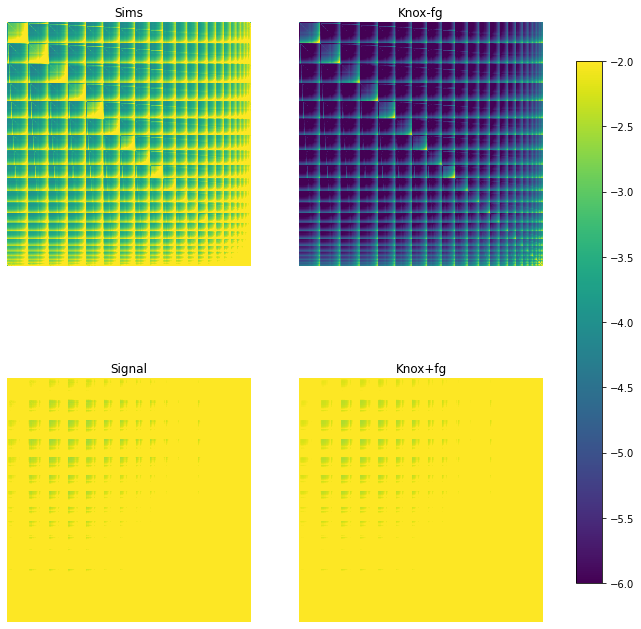

In [71]:
binell=0

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
data_list = [np.log10(abs(cov_sim[binell])),np.log10(abs(cov_an[binell])), np.log10(abs(cov_sg[binell])), np.log10(abs(cov_anfg[binell]))]
titles = ["Sims", "Knox-fg", "Signal", "Knox+fg"]
for ax, data, title in zip(axes.flat, data_list, titles):
    im = ax.imshow(data,vmax=-2,vmin=-6)
    ax.set_title(title)
    ax.axis("off")
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.savefig('./cov_full.pdf')
plt.show()

In [72]:
#correl
def covtocorr(cov):
    std_dev = np.sqrt(np.diag(cov)) 
    outer_std = np.outer(std_dev, std_dev) 
    corr = cov / outer_std  
    return corr

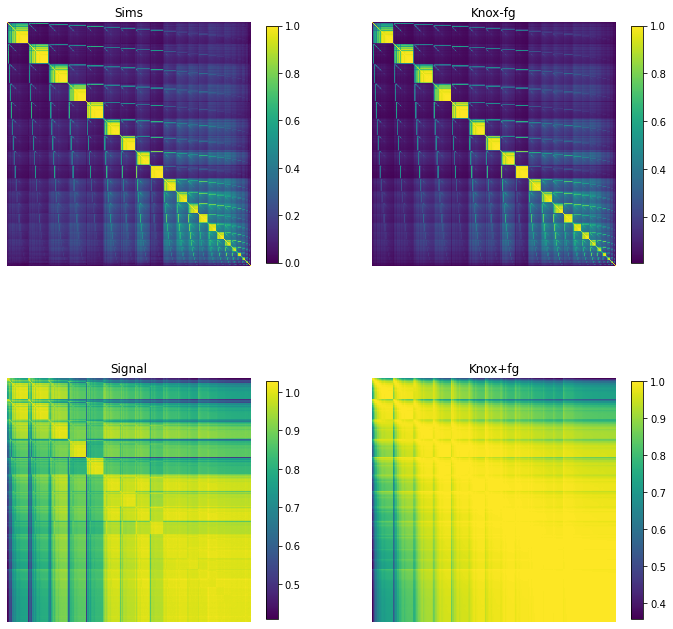

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
data_list = [covtocorr(cov_sim[binell]),covtocorr(cov_an[binell]), covtocorr(cov_sg[binell]), covtocorr(cov_anfg[binell])]
titles = ["Sims", "Knox-fg", "Signal", "Knox+fg"]
for ax, data, title in zip(axes.flat, data_list, titles):
    im = ax.imshow(data,vmax=data.max(),vmin=data.min())
    ax.set_title(title)
    ax.axis("off")
    fig.colorbar(im, ax=ax, shrink=0.8)  # Ajout d'une colorbar pour chaque subplotplt.savefig('./corr_full.pdf')
plt.savefig('./corr_full.pdf')
plt.show()

In [36]:
#invertible?

compute_analytical_cov(DL_signal=DLdc[:,:,:ELLBOUND],DLcross_fg=DLcross_fg,DL_cross_lens=DL_cross_lens,DL_cross_noise=DL_cross_noise,type='Knox-fg',ell=leff,Nlbin=10,mask=mask,Linv=True)


array([[[ 1.16801388e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.16830590e+00,  5.78724716e+03,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.36393751e+00, -2.46096926e+03,  9.53604288e+03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-1.12940019e-02, -5.18333811e-05, -4.39675156e-05, ...,
          7.70390464e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.37629892e-01,  2.22667955e+01,  1.17627619e+01, ...,
         -2.13859512e-01,  4.47199390e+00,  0.00000000e+00],
        [-9.08532543e-04, -3.78630516e-06, -3.16474880e-06, ...,
         -2.70400104e-02, -3.09550979e-02,  1.36299195e+00]],

       [[ 1.70791819e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.89506883e+00,  1.55152749e+03,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

In [ ]:
#invertible?

compute_analytical_cov(DL_signal=DLdc[:,:,:ELLBOUND],DLcross_fg=DLcross_fg,DL_cross_lens=DL_cross_lens,DL_cross_noise=DL_cross_noise,type='Knox+fg',ell=leff,Nlbin=10,mask=mask,Linv=True)


In [78]:
#invertible?

compute_analytical_cov(DL_signal=DLdc[:,:,:ELLBOUND],DLcross_fg=None,DL_cross_lens=None,DL_cross_noise=None,type='signal',ell=leff,Nlbin=10,mask=mask,Linv=True)

LinAlgError: Matrix is not positive definite

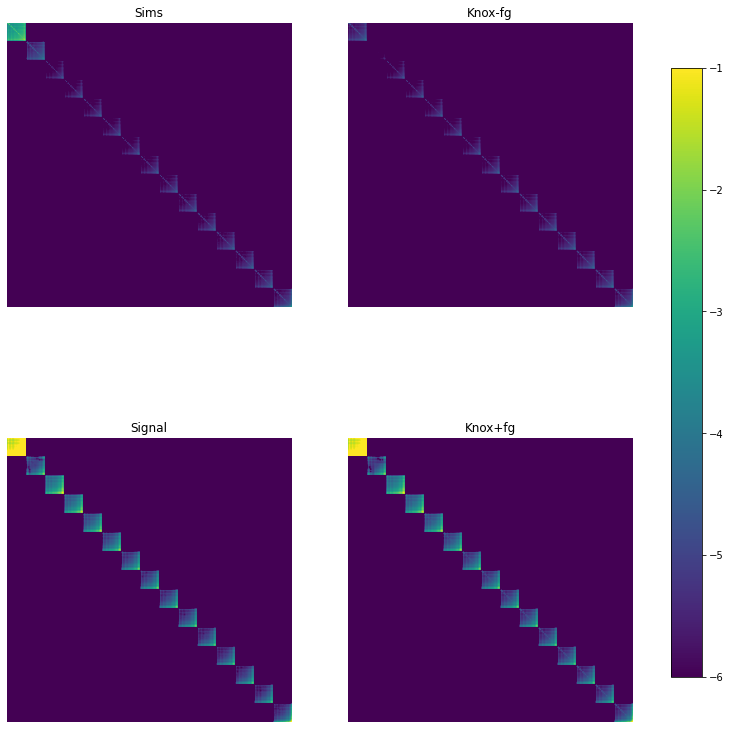

In [84]:
def block_diag(a_list):
    return np.block([[a_list[i] if i == j else np.zeros_like(a_list[0]) 
                      for j in range(len(a_list))] 
                      for i in range(len(a_list))])

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
data_list = [np.log10(abs(block_diag(cov_sim)+1e-12)),np.log10(abs(block_diag(cov_an)+1e-12)), np.log10(abs(block_diag(cov_sg)+1e-12)), np.log10(abs(block_diag(cov_anfg)+1e-12))]
titles = ["Sims", "Knox-fg", "Signal", "Knox+fg"]
for ax, data, title in zip(axes.flat, data_list, titles):
    im = ax.imshow(data,vmax=-1,vmin=-6)
    ax.set_title(title)
    ax.axis("off")
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.savefig('./cov_full_ellell.pdf',dpi=600)
plt.show()